In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def read_in_csv(file_path):
    global produccion
    """
    Read in the specified csv as a pandas dataframe
    Arguments: 
        file_path: String. Path for the csv file that we want to read in
    Outputs:
        dataframe: Pandas dataframe.
    """
    produccion=pd.read_csv(file_path,index_col=0,parse_dates=True)
    return produccion

In [2]:
%pwd

'/home/dsxuser/work'

In [3]:
path = r"/Users/fffte/Documents/GitHub/Ainda/Proyecto Newton/02_productividad/benchmark/" 
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
df = pd.DataFrame()
for f in files_csv:
    data = pd.read_csv(path+f,
                       header='infer',
                       index_col=8,
                       parse_dates=True,
                       infer_datetime_format=True,
                       low_memory=False)
    
    df = df.append(data,sort=True)
    
df2=df.set_index(pd.DatetimeIndex(df['PRODUCTION DATE']))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fffte/Documents/GitHub/Ainda/Proyecto Newton/02_productividad/benchmark/'

In [4]:
display(df2.head())

NameError: name 'df2' is not defined

In [5]:
df2.plot(figsize=(20,10))

NameError: name 'df2' is not defined

In [81]:
#df2.to_csv('us_benchmark.csv')

In [82]:
import timeit
tic=timeit.default_timer()
DF=pd.read_csv('us_benchmark.csv',low_memory=False)
toc=timeit.default_timer()
toc - tic #elapsed time in seconds


104.67778211599943

In [83]:
DF.max()

PRODUCTION DATE             2019-02-01
API NUMBER               ="UNASSIGNED"
CO2, MSCF                  3.55756e+06
GAS, MSCF                  4.62895e+08
NUMBER OF DAYS ONLINE            11254
OIL, BARRELS               3.56272e+06
PRODUCTION DATE.1           2019-02-01
STATE                               WV
WATER, BARRELS             4.61276e+06
dtype: object

In [84]:
DF.describe()

,"CO2, MSCF","GAS, MSCF",NUMBER OF DAYS ONLINE,"OIL, BARRELS","WATER, BARRELS"
count,1.791621e+06,2.070402e+07,7.717386e+06,2.070402e+07,9.610639e+06
mean,2.207243e+03,2.986311e+03,5.736124e+01,6.930346e+02,1.941380e+04
std,4.758904e+04,1.450688e+05,1.803786e+02,6.618794e+03,1.019817e+05
min,0.000000e+00,-5.815300e+04,0.000000e+00,-3.885000e+03,-6.172600e+04
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,4.290000e+02,2.900000e+01,0.000000e+00,1.200000e+01
75%,0.000000e+00,1.708000e+03,3.100000e+01,6.000000e+00,1.920000e+03
max,3.557560e+06,4.628950e+08,1.125400e+04,3.562720e+06,4.612760e+06


In [87]:
us_production=DF.set_index('PRODUCTION DATE')
us_oil=us_production['OIL, BARRELS']

In [88]:
us_oil

PRODUCTION DATE
1967-03-01    17020.0
1967-12-01    25225.0
1967-11-01    26387.0
1967-08-01    22615.0
1967-08-01       75.0
               ...   
2011-11-01        0.0
2011-10-01        0.0
2011-07-01        0.0
2011-05-01        0.0
2011-02-01        0.0
Name: OIL, BARRELS, Length: 20704022, dtype: float64

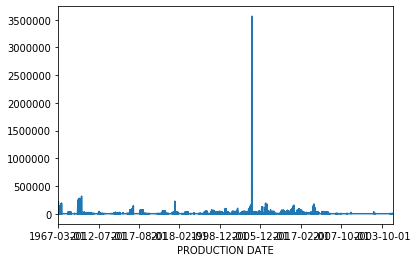

In [90]:
us_oil.plot()

#### original
path = r"/Users/fffte/Google Drive (francisco.tenorio@aindaconsultores.com)/python/notebooks/ejemplos/#electricity/demanda/" 
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
df = pd.DataFrame()
for f in files_csv:
data = pd.read_csv(path+f,sep=',',names=['Sistema',
                                        'Area',
                                        'Hora',
                                        'Generacion (MWh)',
                                        'Estimacion de Demanda por Balance (MWh)',
                                        'Exportacion (MWh)'],
                                        index_col=[0,1],
                                        quotechar='"',
                                        doublequote=True,engine='c')

fecha=0
fecha = re.search(r'\d{4}-\d{2}-\d{2}', f)
fecha = fecha.group()
data['Fecha']=fecha

df = df.append(data,sort=False)

In [92]:
mx_produccion=pd.read_csv('produccion.csv')

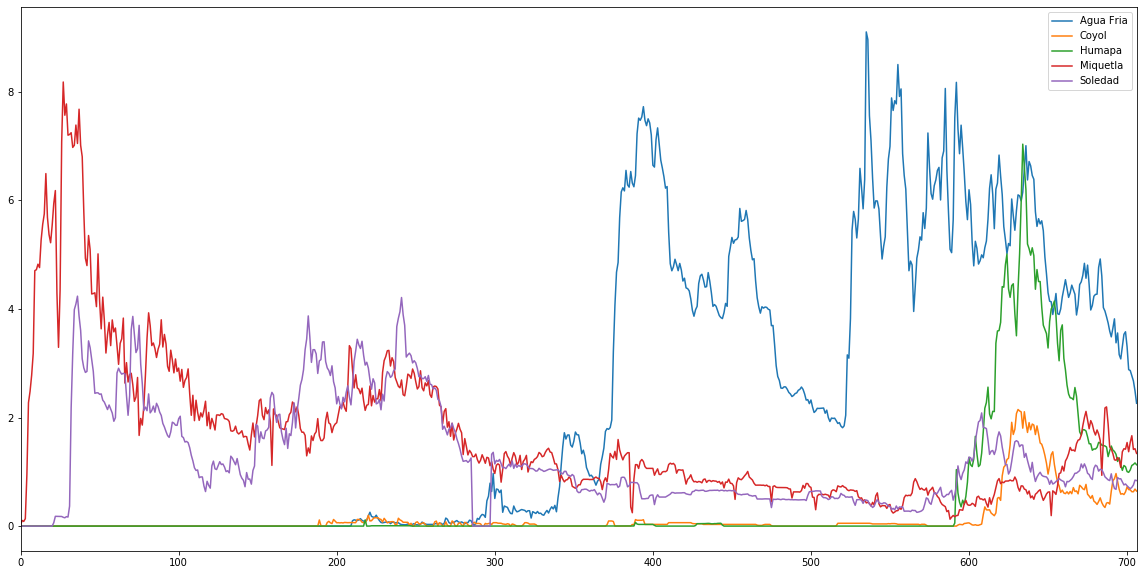

In [94]:
mx_produccion.plot(figsize=(20,10))

In [29]:
def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

In [30]:
def exponential_equation(t, qi, di):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi*np.exp(-di*t)

In [34]:
def remove_nan_and_zeroes_from_columns(df, variable):
    """
    This function cleans up a dataframe by removing rows in a specific 
    column that are null/NaN or equal to 0. This basically removes zero 
    production time periods.
    Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
    Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
    """
    filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
    return filtered_df

In [51]:
remove_nan_and_zeroes_from_columns(produccion,['Agua Fria','Miquetla','Soledad','Coyol','Humapa'])

,Agua Fria,Coyol,Humapa,Miquetla,Soledad
Fecha,,,,,
1960-03-01,NaN,NaN,NaN,0.021,NaN
1960-04-01,NaN,NaN,NaN,0.104,NaN
1960-05-01,NaN,NaN,NaN,0.086,NaN
1960-06-01,NaN,NaN,NaN,0.136,NaN
1960-07-01,NaN,NaN,NaN,0.955,NaN
...,...,...,...,...,...
2018-09-01,2.866,0.668,1.035,1.546,0.688
2018-10-01,2.770,0.633,1.117,1.665,0.714
2018-11-01,2.674,0.632,1.135,1.412,0.757


In [44]:
def generate_time_delta_column(df, time_column, date_first_online_column):
    """
    Create column for the time that a well has been online at each reading, with 
    the first non-null month in the series listed as the start of production
    Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
    Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
    """
    return (df[time_column]-df[date_first_online_column]).dt.days

In [47]:
generate_time_delta_column(produccion,'Fecha','Fecha')

KeyError: 'Fecha'

In [36]:
def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
    """
    This function obtains the min or max value for a column, with a group by applied. For example,
    it could return the earliest (min) RecordDate for each API number in a dataframe 
    Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
    Outputs:
        value: Depends on the calc_column type.
    """
    value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
    return value

In [37]:
def get_max_initial_production(df, number_first_months, variable_column, date_column):
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    """
    #First, sort the data frame from earliest to most recent prod date
    df=df.sort_values(by=date_column)
    #Pull out the first x months of production, where number_first_months is x
    df_beginning_production=df.head(number_first_months)
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return df_beginning_production[variable_column].max()

In [38]:
def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    """
    #Plot results
    df.plot(x=x_variable, y=y_variables, title=plot_title)
    plt.show()

In [32]:
def main():
    #Read in the monthly oil and gas data
    file_path='master_dataframe_production.csv'
    bakken_data=read_in_csv(file_path)
    #Perform some data cleaning to get the columns as the right data type
    bakken_data['ReportDate']=pd.to_datetime(bakken_data['ReportDate'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    desired_product_type='Oil'
    #Remove all rows with null values in the desired time series column
    bakken_data=remove_nan_and_zeroes_from_columns(bakken_data, desired_product_type)
    #Get the earliest RecordDate for each API Number
    bakken_data['Online_Date']= get_min_or_max_value_in_column_by_group(bakken_data, group_by_column='API_WELLNO', 
                  calc_column='ReportDate', calc_type='min')
    #Generate column for time online delta
    bakken_data['Days_Online']=generate_time_delta_column(bakken_data, time_column='ReportDate', 
                  date_first_online_column='Online_Date')
    #Pull data that came online between January and June 2016
    bakken_data_2016=bakken_data[(bakken_data.Online_Date>='2016-01-01') & (bakken_data.Online_Date<='2016-06-01')]
    #Get a list of unique API's to loop through--these were randomly selected as examples
    unique_well_APIs_list=[33023013930000.0, 33105039980000.0, 33105039970000.0, 
                           33013018230000.0, 33013018220000.0]
    #Loop through each API, and perform calculations
    for api_number in unique_well_APIs_list:
        #Subset the dataframe by API Number
        production_time_series=bakken_data_2016[bakken_data_2016.API_WELLNO==api_number]
        #Get the highest value of production in the first three months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 3, desired_product_type, 'ReportDate')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['Days_Online'], 
                                     production_time_series[desired_product_type],bounds=(0, [qi,20]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['Days_Online'], 
                                     production_time_series[desired_product_type],bounds=(0, [qi,2,20]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['Days_Online'], 
                                  *popt_exp)
        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['Days_Online'], 
                                  *popt_hyp)
        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[desired_product_type, "Hyperbolic_Predicted", "Exponential_Predicted"]
        x_variable='Days_Online'
        #Create the plot title
        plot_title=desired_product_type+' Production for Well API '+str(api_number)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)
                
if __name__== "__main__":
    main()

FileNotFoundError: [Errno 2] File b'master_dataframe_production.csv' does not exist: b'master_dataframe_production.csv'